In [3843]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as datetime
import xgboost as xgb
from sklearn.metrics import f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OrdinalEncoder
import lightgbm as lgb
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
import pickle
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score
import category_encoders as ce
from sklearn.feature_selection import RFE

In [3844]:
# train_bene = pd.read_csv('Train_Beneficiarydata-1542865627584.csv')
# train_inp = pd.read_csv('Train_Inpatientdata-1542865627584.csv')
# train_out = pd.read_csv('Train_Outpatientdata-1542865627584.csv')
# train_y = pd.read_csv('Train-1542865627584.csv')

# train_inp_merge = pd.merge(train_bene, train_inp)
# train_out_merge = pd.merge(train_bene, train_out)
# train_df = pd.concat([train_inp_merge, train_out_merge])
# train_df = pd.merge(train_df, train_y)
# #[i for i in train_inp_out_merge.columns if 'DOD' in i]
# #train_inp_out_merge
# train_df.columns

# train_df['ClmAdmitDiagnosisCode'].head(50)

In [3845]:
def data_preprocess():
    
    #merge train and test pdfs
    train_bene = pd.read_csv('Train_Beneficiarydata-1542865627584.csv')
    train_inp = pd.read_csv('Train_Inpatientdata-1542865627584.csv')
    train_out = pd.read_csv('Train_Outpatientdata-1542865627584.csv')
    train_y = pd.read_csv('Train-1542865627584.csv')

    train_inp['Admitted'] = 1
    train_out['Admitted'] = 0
    

    train_bene.head()
    train_inp_merge = pd.merge(train_bene, train_inp)
    train_out_merge = pd.merge(train_bene, train_out)
    train_df = pd.concat([train_inp_merge, train_out_merge])
    train_df = pd.merge(train_df, train_y)
        
    #Set Nan values for Deductible Amt to 0
    train_df['DeductibleAmtPaid'] = np.where(train_df['DeductibleAmtPaid'].isnull(), 0, train_df['DeductibleAmtPaid'])
    
    #replacing 2s with 1s - so that 0 is no and yes is 1
    chronic_cond_features = ['Gender', 'ChronicCond_Alzheimer', 'ChronicCond_Heartfailure', 'ChronicCond_KidneyDisease',
                           'ChronicCond_Cancer', 'ChronicCond_ObstrPulmonary', 'ChronicCond_Depression', 
                           'ChronicCond_Diabetes', 'ChronicCond_IschemicHeart', 'ChronicCond_Osteoporasis', 
                           'ChronicCond_rheumatoidarthritis', 'ChronicCond_stroke']

    for i in chronic_cond_features:
        train_df[i] = np.where(train_df[i] == 2,0,1)
    

    #Replacing 'Y' with 1 in RenalDiseaseIndicator
    train_df['RenalDiseaseIndicator'] = np.where(train_df['RenalDiseaseIndicator'] == 'Y',1,0)
    
    #Converting Yes/NO in target variable to boolean
    train_df['PotentialFraud'] = np.where(train_df['PotentialFraud'] == 'Yes',1, 0)
    
    #print(train_df.isnull().sum(axis = 0))
    #print(train_df.head(5))
    return train_df
   


In [3846]:
def feature_engineering(train_df, num_vec_params):
    
    chronic_cond_features = ['ChronicCond_Alzheimer', 'ChronicCond_Heartfailure', 'ChronicCond_KidneyDisease',
                           'ChronicCond_Cancer', 'ChronicCond_ObstrPulmonary', 'ChronicCond_Depression', 
                           'ChronicCond_Diabetes', 'ChronicCond_IschemicHeart', 'ChronicCond_Osteoporasis', 
                           'ChronicCond_rheumatoidarthritis', 'ChronicCond_stroke']
    
    # Create boolean for dead/alive
    train_df['dead'] = np.where(train_df['DOD'].isnull(), 0, 1)

    # Create variable for length of claim
    train_df['claim_duration'] = (pd.to_datetime(train_df['ClaimEndDt']) - pd.to_datetime(train_df['ClaimStartDt'])).dt.days
    

    # Create variable for length of admission
    train_df['admission_length'] = (pd.to_datetime(train_df['DischargeDt']) - pd.to_datetime(train_df['AdmissionDt'])).dt.days
   
    #makes outpatient admission length equal to 0 days
    train_df['admission_length'] = np.where(train_df['admission_length'].isnull(), 0, train_df['admission_length'])
    
    #age variable
    train_df['age'] = (pd.to_datetime(train_df['ClaimStartDt']) - pd.to_datetime(train_df['DOB'])).dt.days //365
    
    #Number of physicians variable
    train_df['num_physicians'] = train_df[['AttendingPhysician', 'OperatingPhysician', 'OtherPhysician']].notnull().sum(axis = 1)
    
    #Number of procedures variable
    train_df['num_procedures'] = train_df[['ClmProcedureCode_{}'.format(x) for x in range(1,7)]].notnull().sum(axis = 1)
    
    #Claim Diagnosis code variables
    ClmDiagnosisCode_vars =['ClmAdmitDiagnosisCode'] + ['ClmDiagnosisCode_{}'.format(x) for x in range(1, 11)]
    train_df['num_claims'] = train_df[ClmDiagnosisCode_vars].notnull().sum(axis = 1)
    
    
    #total claim amount
    train_df['TotalClaimAmt'] = train_df['InscClaimAmtReimbursed'] + train_df['DeductibleAmtPaid']
    
    
    train_df['IPTotalAmount'] = train_df['IPAnnualReimbursementAmt'] + train_df['IPAnnualDeductibleAmt']

    # Total Outpatient Amount = Outpatient Annual Amount reimbursed + Outpatient Annual Deductible Amount
    train_df['OPTotalAmount'] = train_df['OPAnnualReimbursementAmt'] + train_df['OPAnnualDeductibleAmt']
    
    #Number of Chronic Conditions
    train_df['num_conditions'] = train_df[chronic_cond_features].notnull().sum(axis = 1)
    

    # Define the columns and their corresponding top_n values in a dictionary
    columns_to_encode = {
        'State': num_vec_params['state_num_vec'],
        'ClmDiagnosisCode_1': num_vec_params['codes_num_vec'],
        'ClmDiagnosisCode_2': num_vec_params['code2_num_vec'],
        'ClmDiagnosisCode_3': num_vec_params['code3_num_vec'],
        'AttendingPhysician': num_vec_params['phys_num_vec'],
        'County': num_vec_params['county_num_vec']
    }

    train_df = ordinal_encoder(train_df, 'State', columns_to_encode['State'])
    train_df = ordinal_encoder(train_df, 'ClmDiagnosisCode_1', columns_to_encode['ClmDiagnosisCode_1'])
    train_df = ordinal_encoder(train_df, 'ClmDiagnosisCode_2', columns_to_encode['ClmDiagnosisCode_2'])
    train_df = ordinal_encoder(train_df, 'ClmDiagnosisCode_3', columns_to_encode['ClmDiagnosisCode_3'])
    train_df = ordinal_encoder(train_df, 'AttendingPhysician', columns_to_encode['AttendingPhysician'])
    train_df = ordinal_encoder(train_df, 'County', columns_to_encode['County'])

    # Fit and transform the encoder on the training data
    
    return train_df
    
    

In [3847]:
def recursive_feature_elimination(model, data, features, num_features = 20):


    rfe = RFE(estimator=model, n_features_to_select=num_features)
    rfe.fit(data[features], data['PotentialFraud'])
    selected_features = rfe.support_
    reduced_features = data[features].loc[:, selected_features]
    return reduced_features.columns.tolist()

In [3848]:
def ordinal_encoder(df, column, top_n):
    
    top_indices = df[column].value_counts()[:top_n].index
    df[column] = np.where(df[column].isin(top_indices), df[column], 'Other')
    
    encoder = OrdinalEncoder()
    df[column] = encoder.fit_transform(df[[column]])

    return df

In [3849]:
def train_test_split(train_df, split_frac = .25):
    # Split the data into train, validate, and test sets
    train, validate, test = np.split(train_df.sample(frac=1, random_state=42),
                                     [int((1-2*split_frac) * len(train_df)), int((1-split_frac) * len(train_df))])
    return train, validate, test

In [3850]:
def train_model(train, features, model_inst):

    model_inst.fit(train[features], train['PotentialFraud'])

    return model_inst

In [3851]:
def hyperparameter_tuning(model, param_grid, validate, features, num_iter=10):
    # Perform grid search with cross-validation
    random_search = RandomizedSearchCV(estimator= model, param_distributions=param_grid, n_iter=num_iter, scoring='f1', cv = 3)
    #grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring='f1', cv=3)
    random_search.fit(validate[features], validate['PotentialFraud'])

    best_params = random_search.best_params_
    best_model = random_search.best_estimator_

    return best_model, best_params

In [3852]:
def evaluate_model(model, data, features, threshold = 0.5):
    y_pred = model.predict(data[features])

    y_proba = model.predict_proba(data[features])[:, 1]
    y_pred_thresholded = np.where(y_proba >= threshold, 1, 0)
    
    f1_score_val = f1_score(data['PotentialFraud'], y_pred_thresholded)
    return f1_score_val

In [3853]:
def confusion_matrix_cust(model, data, features, threshold = 0.5):
    y_pred = model.predict(data[features])
    
    y_proba = model.predict_proba(data[features])[:, 1]
    print(y_proba.mean(), y_proba.std())
    y_pred_thresholded = np.where(y_proba >= threshold, 1, 0)
    
    # Create the confusion matrix
    cm = confusion_matrix(data['PotentialFraud'], y_pred_thresholded)
    return cm

In [3854]:
def auc_roc(model, data, features):
    
    y_probs = model.predict_proba(data[features])[:, 1]
    fpr, tpr, thresholds = roc_curve(data['PotentialFraud'], y_probs)
    
    auc_roc_score = roc_auc_score(data['PotentialFraud'], y_probs)
    
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='blue', lw=2, label=f'AUC = {auc_roc_score:.2f}')
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
    plt.xlabel('False Positive Rate (FPR)')
    plt.ylabel('True Positive Rate (TPR) or Recall')
    plt.title('ROC Curve')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.show()

In [3855]:
df = data_preprocess()
print(df.columns)

Index(['BeneID', 'DOB', 'DOD', 'Gender', 'Race', 'RenalDiseaseIndicator',
       'State', 'County', 'NoOfMonths_PartACov', 'NoOfMonths_PartBCov',
       'ChronicCond_Alzheimer', 'ChronicCond_Heartfailure',
       'ChronicCond_KidneyDisease', 'ChronicCond_Cancer',
       'ChronicCond_ObstrPulmonary', 'ChronicCond_Depression',
       'ChronicCond_Diabetes', 'ChronicCond_IschemicHeart',
       'ChronicCond_Osteoporasis', 'ChronicCond_rheumatoidarthritis',
       'ChronicCond_stroke', 'IPAnnualReimbursementAmt',
       'IPAnnualDeductibleAmt', 'OPAnnualReimbursementAmt',
       'OPAnnualDeductibleAmt', 'ClaimID', 'ClaimStartDt', 'ClaimEndDt',
       'Provider', 'InscClaimAmtReimbursed', 'AttendingPhysician',
       'OperatingPhysician', 'OtherPhysician', 'AdmissionDt',
       'ClmAdmitDiagnosisCode', 'DeductibleAmtPaid', 'DischargeDt',
       'DiagnosisGroupCode', 'ClmDiagnosisCode_1', 'ClmDiagnosisCode_2',
       'ClmDiagnosisCode_3', 'ClmDiagnosisCode_4', 'ClmDiagnosisCode_5',
       'Cl

In [3856]:
# Train-Test Split
train, validate, test = train_test_split(df, split_frac = 0.25)

In [3857]:
num_vec_params = {
    'code3_num_vec': 3,
    'code2_num_vec': 3,
    'codes_num_vec': 3,
    'phys_num_vec': 750,
    'state_num_vec': 50,
    'county_num_vec': 50
}

train = feature_engineering(train, num_vec_params)
validate = feature_engineering(validate, num_vec_params)
test = feature_engineering(test, num_vec_params)

#print(train_df[['num_claims', 'num_physicians', 'age']].mean(axis = 0))

In [3858]:
# Define the features
features = ['Admitted', 'num_claims', 'num_physicians', 'num_procedures', 'num_conditions', 'age', 'dead', 'admission_length', 'claim_duration', 'TotalClaimAmt', 'Gender',
            'ChronicCond_Cancer', 'ChronicCond_Alzheimer', 'ChronicCond_Heartfailure', 'ChronicCond_KidneyDisease', 'ChronicCond_Diabetes', 'ChronicCond_IschemicHeart', 'RenalDiseaseIndicator', 'ChronicCond_ObstrPulmonary', 'ChronicCond_Depression',
            'ChronicCond_Osteoporasis', 'ChronicCond_rheumatoidarthritis', 'ChronicCond_stroke', 'ClmDiagnosisCode_1', 'ClmDiagnosisCode_2', 'ClmDiagnosisCode_3', 'Race', 'State', 'County', 'AttendingPhysician', 'OPTotalAmount', 'IPTotalAmount'
           ] 
 
#hyperparameter grid search
param_grid_xg = {
    'max_depth': [3,5,7],
    'learning_rate': [0.1, 0.01],
    'n_estimators': [100, 200, 300],
    'subsample': [0.4, 0.6, 0.8],
    'colsample_bytree': [0.4, 0.6, 0.8],
    'lambda': [0, 0.25, 0.5, 1.0]
}

param_grid_lgbm = {
    
    'num_leaves': [31, 50, 100],  # Example values to try
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [100, 200, 300]
    
}

param_grid_rf = {
    'n_estimators': [50, 100, 200, 300],           # Number of trees in the forest
    'max_depth': [5, 10, 15, 20],               # Maximum depth of each tree
    'min_samples_split': [3,4,5],           # Minimum number of samples required to split an internal node
    'min_samples_leaf': [2,3,4]               # Minimum number of samples required to be at a leaf node
}


model_instances = {
        'xgb': xgb.XGBClassifier(), 'lgbm': lgb.LGBMClassifier(), 
        'lr': LogisticRegression(), 'rf': RandomForestClassifier()
}

In [3859]:
features = recursive_feature_elimination(model_instances['xgb'], train, features, num_features = 15)

In [3860]:
# Train the models
#rf_model = train_model(train, features, model_instances['rf'])
xgb_model = train_model(train, features, model_instances['xgb'])
#lgbm_model = train_model(train, features, model_instances['lgbm'])


In [3861]:
xgb_f1_train_score = evaluate_model(xgb_model, train, features, threshold = 0.38)
#lreg_f1_train_score = evaluate_model(logistic_model, train, features)
#lgbm_f1_train_score = evaluate_model(lgbm_model, train, features, threshold = 0.38)
#rf_f1_train_score = evaluate_model(rf_model, train, features, threshold = 0.38)

#xgb_f1_score = evaluate_model(tuned_xgb_model, test, features)
#print('rf:', rf_f1_train_score)
print('xgb:', xgb_f1_train_score)
#print('lgb:', lgbm_f1_train_score)
#print('xgb_test:', xgb_f1_score)


xgb: 0.7381683807488535


In [3862]:
#hyperparameter tune


tuned_xgb_model, best_params_xgb = hyperparameter_tuning(xgb_model, param_grid_xg, validate, features)
#tuned_lgbm_model, best_params_lgbm = hyperparameter_tuning(lgbm_model, param_grid_lgbm, validate, features)
#tuned_rf_model, best_params = hyperparameter_tuning(rf_model, param_grid_rf, validate, features)

In [3863]:
# Open the file in binary write mode ('wb') to save the data
# with open('rf_hyperparams.pkl', 'wb') as file:
#     pickle.dump(tuned_rf_model, file)

with open('xgb_hyperparams.pkl', 'wb') as file:
    pickle.dump(tuned_xgb_model, file)
    
# with open('lgbm_hyperparams.pkl', 'wb') as file:
#     pickle.dump(tuned_lgbm_model, file)

In [3864]:
with open('xgb_hyperparams.pkl', 'rb') as file:
    tuned_xgb_model = pickle.load(file)


# with open('lgbm_hyperparams.pkl', 'rb') as file:
#         tuned_lgbm_model = pickle.load(file)

# with open('rf_hyperparams.pkl', 'rb') as file:
#         tuned_rf_model = pickle.load(file)

0.37562084 0.23696066


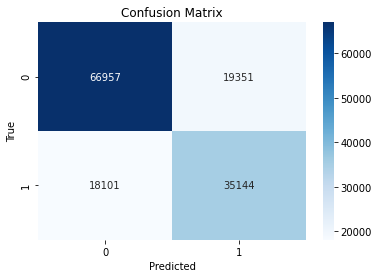

PotentialFraud
0    86308
1    53245
Name: count, dtype: int64

In [3865]:
# Create the confusion matrix
cm = confusion_matrix_cust(tuned_xgb_model, test, features, threshold = 0.369)

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')

plt.show()

test['PotentialFraud'].value_counts()

In [3866]:
# rf_f1_test_score = evaluate_model(tuned_xgb_model, test, features, threshold = 0.38)
# print(rf_f1_test_score)

xgb_f1_test_score = evaluate_model(tuned_xgb_model, test, features, threshold = 0.38)
print(xgb_f1_test_score)

# lgbm_f1_test_score = evaluate_model(tuned_lgbm_model, test, features, threshold = 0.365)
# print(lgbm_f1_test_score)

0.6509648127128264


In [3867]:
print(best_params_xgb)

{'subsample': 0.6, 'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.1, 'lambda': 0.5, 'colsample_bytree': 0.8}


In [3868]:
# file_path = 'xgb_model.pkl'

# with open(file_path, 'wb') as f:
#     pickle.dump(tuned_xgb_model, f)


# file_path = 'lgbm_model.pkl'

# with open(file_path, 'wb') as f:
#     pickle.dump(tuned_lgbm_model, f)


# file_path = 'rf_model.pkl'

# with open(file_path, 'wb') as f:
#     pickle.dump(tuned_rf_model, f)


In [3869]:
feat_imp = np.round(xgb_model.feature_importances_, 3)
print(sorted(list(zip(features, feat_imp)), key = lambda x: x[1], reverse = True))

[('Admitted', 0.476), ('AttendingPhysician', 0.178), ('State', 0.148), ('County', 0.1), ('admission_length', 0.018), ('ChronicCond_Alzheimer', 0.01), ('TotalClaimAmt', 0.009), ('ChronicCond_stroke', 0.009), ('ClmDiagnosisCode_3', 0.009), ('OPTotalAmount', 0.009), ('Race', 0.008), ('IPTotalAmount', 0.008), ('claim_duration', 0.006), ('ChronicCond_Diabetes', 0.006), ('RenalDiseaseIndicator', 0.006)]


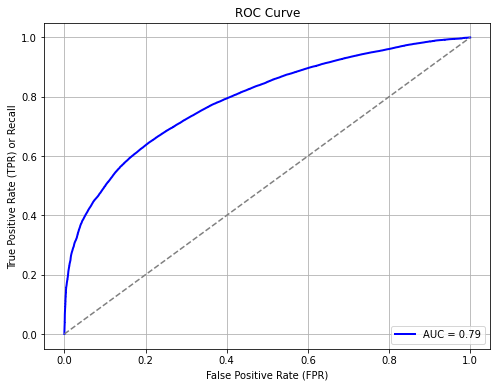

In [3870]:
rf_auc_roc = auc_roc(tuned_xgb_model, test, features)